# Feature Engineering

#### Packages Installation:

In [7]:
# !pip install nlp_primitives
# !pip install bs4
# !pip install spacy
# !pip install gensim
# !pip install nltk
# !pip install seaborn
# ! python -m spacy download en

#### Google Drive Mounting (When executed in google colab):

In [8]:
# from google.colab import drive
# drive.mount("/content/drive", force_remount=True)

In [9]:
import pandas as pd
import numpy as np
import os
import re
import zipfile
import requests
from bs4 import BeautifulSoup
from collections import Counter
import itertools

import spacy
from spacy.tokenizer import Tokenizer
import gensim as gen
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import featuretools as ft
import featuretools.variable_types as vtypes
from featuretools.primitives import  AggregationPrimitive
from nlp_primitives import (
    DiversityScore,
    LSA,
    MeanCharactersPerWord,
    PolarityScore, 
    UniversalSentenceEncoder,
    PunctuationCount,
    StopwordCount,
    TitleWordCount,
    UpperCaseCount)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureW

In [10]:
AMBIGUOUS_WORDS_URL = 'https://muse.dillfrog.com/lists/ambiguous'

**Path**

In [11]:
# yaniv
# path = "/content/drive/My Drive/Final Project (Personal)/"

# avi
# path = "/content/drive/My Drive/DataScientistITCAvi/Final_Project/Model/Notebooks/"

# cnvrg
path = ""

**Load Dataset:**

In [12]:
df = pd.read_pickle(path+'eda_reddit_jokes.pkl')[:1000]

In [13]:
df.shape

(1000, 2)

In [14]:
df.head()

,joke,score
0,I hate how you cant even say black paint anymo...,1
1,"Brian raises his hand and says, “He’s in Heave...",1
2,I walked into a PETA adoption center and the r...,1
3,Remember when you were a kid and when you crie...,15
4,"My boss said to me, ""you're the worst train dr...",3


**Remove outliers - long jokes:**

In [15]:
df['joke_words'] = df['joke'].apply(lambda x: len(x.split(' ')))

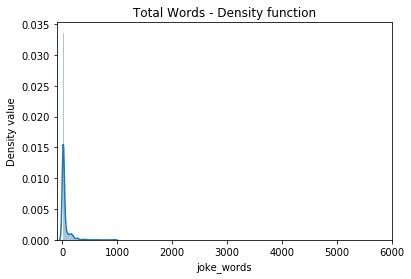

In [16]:
# Feature scaling and outliers removal
# f = plt.figure(figsize=(20,10))
ax = sns.distplot(df[df['joke_words']< 1000]['joke_words']);
ax.set_title('Total Words - Density function');
ax.set_ylabel('Density value');
ax.set_xticks(np.arange(0,7000,1000))
plt.show();

In [17]:
df = df[df['joke_words']<=40].reset_index()
del df['index']
del df['joke_words']

In [18]:
df.shape

(774, 2)

**Load Spacy English Model**

In [19]:
nlp = spacy.load('en')
def en_tokenize(string):
    return nlp(string)

**Sample 20,000 rows:**

In [20]:
df = df.loc[:20000]

## Generate new features

**Ambiguous words counter features:**

In [21]:
def get_ambiguous_words():
  res = requests.get(AMBIGUOUS_WORDS_URL)
  page_soup = BeautifulSoup(res.content)
  a_tags = page_soup.find_all('a', href=re.compile(r'.*/meaning/word/*'))
  ambiguous_words = [word.text for word in a_tags]
  return ambiguous_words

In [22]:
ambiguous_words = get_ambiguous_words()
df['ambiguous_words'] = df['joke'].apply(lambda x: sum([str(w) in ambiguous_words for w in x]))
df['ambiguous_words'].head()

0    4
1    3
2    1
3    1
4    4
Name: ambiguous_words, dtype: int64

**Repetition**

In [23]:
# spacy_col = df['joke'].apply(en_tokenize)
df['joke_tokenized'] = df['joke'].apply(nlp)

In [24]:
token_pos = df['joke_tokenized'].apply(lambda x: [(elm.text, elm.pos_) for elm in x])

In [25]:
from gensim.models import Word2Vec
from nltk.corpus import brown
nltk.download('brown')
b = Word2Vec(brown.sents())

def find_best_similarity(string):
    """ find the max similarity between two words """
    # unique words:
    word_list = list(set([word_pos[0] for word_pos in string if word_pos[1] != "PROPN"]))
    all_combi = list(itertools.combinations(word_list, 2))

    max_similarity = 0
    for pairs in all_combi:
        try:
            temp_similatity = b.similarity(pairs[0], pairs[1])
            if temp_similatity > max_similarity:
                max_similarity = temp_similatity
        except:
            pass # don't found the word in word2vec
    return max_similarity

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [26]:
df['best_score_similarity_words'] = token_pos.apply(find_best_similarity)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  from ipykernel import kernelapp as app


In [27]:
df['best_score_similarity_words'].head()

0    0.921702
1    0.934003
2    0.913090
3    0.786822
4    0.894313
Name: best_score_similarity_words, dtype: float64

**Antoym**

In [28]:
list_of_antonyms=[]
from nltk.corpus import wordnet as wn
for i in wn.all_synsets():
    if i.pos() in ['a', 's']: 
        for j in i.lemmas(): 
            if j.antonyms(): 
                (j.name(), j.antonyms()[0].name()) and list_of_antonyms.append((j.name(), j.antonyms()[0].name()))
dict_antonyms = dict((y, x) for x, y in list_of_antonyms)

def find_antonyms(tokens_poss):
    """ count how many antonyms in sentence """
    word_list = [word_pos[0] for word_pos in tokens_poss]
    count = 0
    for word in word_list:
        try:
            if word in dict_antonyms:
                if dict_antonyms[word] in word_list:
                    count += 1
        except Exception:
            pass # don't found in dict
    return count


In [29]:
df['antonyms'] = token_pos.apply(find_antonyms)

In [30]:
df['antonyms'].head()

0    0
1    0
2    0
3    0
4    0
Name: antonyms, dtype: int64

**Longest word**

In [31]:
def len_longest_word(tokens_poss):
    """ check the length of the longest word """
    word_len_list = [(word_pos[0], len(word_pos[0]))  for word_pos in tokens_poss]
    word_len_list = sorted(word_len_list, key=lambda x: x[1])

    return word_len_list[-1][1]

In [32]:
df['longest_word'] = token_pos.apply(len_longest_word)

In [33]:
df['longest_word'].head()

0     7
1    12
2     8
3     6
4    11
Name: longest_word, dtype: int64

**Special chars counter:**

In [34]:
def count_speical_chars(tokens_poss):
    """ how many speical chars in string """
    bin_isalphanumberic_list = [not word_pos[0].isalnum() for word_pos in tokens_poss]

    return np.sum(bin_isalphanumberic_list)

In [35]:
df['speical_chars'] = token_pos.apply(count_speical_chars)

In [36]:
df['speical_chars'].head()

0     4
1     5
2    14
3     2
4     3
Name: speical_chars, dtype: int64

**Get more features using "featuretools" package:**

In [37]:
es = ft.EntitySet("jokes_df")
es.entity_from_dataframe(entity_id="jokes_df",
                          index="joke_id",
                          make_index=True,
                          dataframe=df)

Entityset: jokes_df
  Entities:
    jokes_df [Rows: 774, Columns: 9]
  Relationships:
    No relationships

In [38]:
"""
DiversityScore()
Calculates the overall complexity of the text based on the total

LSA()
Calculates the Latent Semantic Analysis Values of Text Input

MeanCharactersPerWord()
Determines the mean number of characters per word.

PolarityScore()
Calculates the polarity of a text on a scale from -1 (negative) to 1 (positive)

PunctuationCount()
Determines number of punctuation characters in a string.

StopwordCount()
Determines number of stopwords in a string.

TitleWordCount()
Determines the number of title words in a string.

UpperCaseCount()
Calculates the number of upper case letters in text.
"""

trans = [
#     DiversityScore,
#          LSA,
         MeanCharactersPerWord,
         UniversalSentenceEncoder,
         PolarityScore, 
         PunctuationCount,
         StopwordCount,
         TitleWordCount,
         UpperCaseCount]

**Get sentence Embeddings:**

In [39]:
feature_matrix_customers, features_defs = ft.dfs(entityset=es,
                  target_entity='jokes_df',
                #   instance_ids=["joke"],
                  trans_primitives=trans,
                  max_depth=4)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [57]:
feature_matrix_customers.columns

Index(['score', 'ambiguous_words', 'joke_tokenized',
       'best_score_similarity_words', 'antonyms', 'longest_word',
       'speical_chars', 'MEAN_CHARACTERS_PER_WORD(joke)',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[0]',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[1]',
       ...
       'UNIVERSAL_SENTENCE_ENCODER(joke)[507]',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[508]',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[509]',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[510]',
       'UNIVERSAL_SENTENCE_ENCODER(joke)[511]', 'POLARITY_SCORE(joke)',
       'PUNCTUATION_COUNT(joke)', 'STOPWORD_COUNT(joke)',
       'TITLE_WORD_COUNT(joke)', 'UPPER_CASE_COUNT(joke)'],
      dtype='object', length=525)

In [55]:
df.shape

(774, 9)

In [52]:
feature_matrix_customers.shape

(774, 525)

In [58]:
pd.concat([df['joke'],feature_matrix_customers], axis=1)

,joke,score,ambiguous_words,joke_tokenized,best_score_similarity_words,antonyms,longest_word,speical_chars,MEAN_CHARACTERS_PER_WORD(joke),UNIVERSAL_SENTENCE_ENCODER(joke)[0],...,UNIVERSAL_SENTENCE_ENCODER(joke)[507],UNIVERSAL_SENTENCE_ENCODER(joke)[508],UNIVERSAL_SENTENCE_ENCODER(joke)[509],UNIVERSAL_SENTENCE_ENCODER(joke)[510],UNIVERSAL_SENTENCE_ENCODER(joke)[511],POLARITY_SCORE(joke),PUNCTUATION_COUNT(joke),STOPWORD_COUNT(joke),TITLE_WORD_COUNT(joke),UPPER_CASE_COUNT(joke)
0,I hate how you cant even say black paint anymo...,1,4,"(I, hate, how, you, ca, nt, even, say, black, ...",0.921702,0,7,4,3.863636,0.015197,...,-0.057825,0.019375,0.041815,-0.047018,-0.016727,-0.083,4.0,7,4.0,4.0
1,I walked into a PETA adoption center and the r...,1,3,"(I, walked, into, a, PETA, adoption, center, a...",0.934003,0,12,5,4.750000,-0.033150,...,-0.072915,0.020479,0.054477,-0.046195,0.033442,0.079,5.0,11,5.0,8.0
2,"My boss said to me, ""you're the worst train dr...",3,1,"(My, boss, said, to, me, ,, "", you, 're, the, ...",0.913090,0,8,14,4.035714,-0.066581,...,-0.071312,-0.002545,-0.024180,-0.037230,-0.007027,-0.345,14.0,10,4.0,4.0
3,If I get a bird I'm naming it Trump. cuz all t...,1,1,"(If, I, get, a, bird, I, 'm, naming, it, Trump...",0.786822,0,6,2,3.066667,0.052737,...,-0.036476,0.034615,0.080568,-0.027628,-0.030043,0.000,2.0,6,5.0,5.0
4,What do you call an exercise machine with a st...,2,4,"(What, do, you, call, an, exercise, machine, w...",0.894313,0,11,3,4.538462,-0.018519,...,-0.060269,0.009251,-0.042123,-0.040038,-0.026490,0.000,3.0,5,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,"If Christians have the Daily Bread, what do Bu...",9,0,"(If, Christians, have, the, Daily, Bread, ,, w...",0.691407,0,10,3,4.615385,0.057274,...,-0.044231,0.017226,0.018338,-0.037536,0.020559,0.000,3.0,5,8.0,8.0
770,Get Stoned Before an Auction. Even if you don'...,705,1,"(Get, Stoned, Before, an, Auction, ., Even, if...",0.841521,0,8,5,4.588235,0.080524,...,-0.023813,0.013951,-0.000838,-0.050237,-0.009916,-0.254,5.0,7,5.0,5.0
771,A guy gets arrested for taking a dump.. -Knock...,9,3,"(A, guy, gets, arrested, for, taking, a, dump,...",0.901666,0,11,18,4.290323,0.006009,...,-0.068881,0.009517,-0.027632,-0.058371,-0.074176,-0.222,15.0,9,7.0,7.0
772,How do you know if your roommate is gay?. His ...,35,1,"(How, do, you, know, if, your, roommate, is, g...",0.853853,0,8,3,3.714286,0.075412,...,-0.035785,0.016465,0.071580,-0.046885,0.051856,-0.286,3.0,5,2.0,2.0


In [95]:
print(f'Number of features to add: {len(features_defs)}')

Number of features to add: 14


In [96]:
df = pd.concat([df['joke'],feature_matrix_customers], axis=1)

In [97]:
df.head()

,joke,score,ambiguous_words,joke_tokenized,best_score_similarity_words,antonyms,longest_word,speical_chars,MEAN_CHARACTERS_PER_WORD(joke),UNIVERSAL_SENTENCE_ENCODER(joke)[0],...,UNIVERSAL_SENTENCE_ENCODER(joke)[507],UNIVERSAL_SENTENCE_ENCODER(joke)[508],UNIVERSAL_SENTENCE_ENCODER(joke)[509],UNIVERSAL_SENTENCE_ENCODER(joke)[510],UNIVERSAL_SENTENCE_ENCODER(joke)[511],POLARITY_SCORE(joke),PUNCTUATION_COUNT(joke),STOPWORD_COUNT(joke),TITLE_WORD_COUNT(joke),UPPER_CASE_COUNT(joke)
0,I hate how you cant even say black paint anymo...,1,4,"(I, hate, how, you, ca, nt, even, say, black, ...",0.919571,0,7,4,3.863636,0.015197,...,-0.057825,0.019375,0.041815,-0.047018,-0.016727,-0.083,4.0,7,4.0,4.0
1,I walked into a PETA adoption center and the r...,1,3,"(I, walked, into, a, PETA, adoption, center, a...",0.934883,0,12,5,4.750000,-0.033150,...,-0.072915,0.020479,0.054477,-0.046195,0.033442,0.079,5.0,11,5.0,8.0
2,"My boss said to me, ""you're the worst train dr...",3,1,"(My, boss, said, to, me, ,, "", you, 're, the, ...",0.913511,0,8,14,4.035714,-0.066581,...,-0.071312,-0.002545,-0.024180,-0.037230,-0.007027,-0.345,14.0,10,4.0,4.0
3,If I get a bird I'm naming it Trump. cuz all t...,1,1,"(If, I, get, a, bird, I, 'm, naming, it, Trump...",0.786436,0,6,2,3.066667,0.052737,...,-0.036476,0.034615,0.080568,-0.027628,-0.030043,0.000,2.0,6,5.0,5.0
4,What do you call an exercise machine with a st...,2,4,"(What, do, you, call, an, exercise, machine, w...",0.894936,0,11,3,4.538462,-0.018519,...,-0.060269,0.009251,-0.042123,-0.040038,-0.026490,0.000,3.0,5,2.0,2.0


**Add object counter features:**

In [98]:
# df['joke_tokenized'] = df['joke'].apply(nlp)

In [100]:
def add_object_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.label_ for ent in x.ents])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df


In [101]:
df['joke_tokenized'].apply(lambda x: [ent.label_ for ent in x.ents])

0          [PERSON]
1                []
2            [DATE]
3         [PRODUCT]
4                []
            ...    
19996            []
19997      [PERSON]
19998         [ORG]
19999    [CARDINAL]
20000         [GPE]
Name: joke_tokenized, Length: 20001, dtype: object

In [102]:
df = add_object_count_cols(df,'joke_tokenized')

In [103]:
df.shape

(20001, 544)

**Add Part-of-Speech features:**

In [104]:
def add_pos_count_cols(df,tokenized_col):
  df['temp'] = df[tokenized_col].apply(lambda x: [ent.pos_ for ent in x])
  mlb = MultiLabelBinarizer()
  mlb.fit(df['temp'])
  df = df.join(pd.DataFrame(mlb.transform(df['temp']),
                            columns=mlb.classes_,
                            index=df.index))
  del df['temp']
  return df

In [105]:
df = add_pos_count_cols(df,'joke_tokenized')

In [106]:
df.shape

(20001, 562)

## Text pre-processing

**Text cleaning:**

In [107]:
def replace_non_eng_punct(txt):
    return re.sub(r'/[^a-zA-Z0-9\s,.?!]/','*',txt).strip()

In [108]:
def replace_escape(txt):
    updated_txt = re.sub(r'\n|\t|&amp;',' ',txt)
    return updated_txt.strip()

In [109]:
def remove_multi_spaces(txt):
    return re.sub(' +', ' ',txt)

In [110]:
def preprocess_text(document):
  #         # Remove all the special characters
  document = re.sub(r'\W', ' ', str(document))

  #         # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

  #         # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)

  # Converting to Lowercase
  document = document.lower()

  return document

In [111]:
df['joke_text_processed'] = df['joke'].apply(replace_non_eng_punct).apply(remove_multi_spaces).apply(replace_escape)

In [112]:
df['joke_text_processed'] = df['joke_text_processed'].apply(preprocess_text)

In [113]:
df['joke_processed_tokenized'] = df['joke_text_processed'].apply(nlp)

In [114]:
df['joke_processed_tokenized'][55]

people in california at first people in california were like oh we don have enough water and now they re like oh we have too much water ___ they can make up their dam minds 

**Lemmatization:**

In [115]:
stemmer = WordNetLemmatizer()
stop_words = stopwords.words('english')
lemmatize_remove_stop_words = lambda x: nlp(' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words]))
lemmatize_remove_stop_words_str = lambda x: ' '.join([stemmer.lemmatize(str(word)) for word in x if str(word) not in stop_words])

In [116]:
df['joke_processed_tokenized_stemmed'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words)
df['joke_processed_tokenized_stemmed_str'] = df['joke_processed_tokenized'].apply(lemmatize_remove_stop_words_str)

**Build total words / total chars features:**

In [119]:
df['total_words'] = df['joke_tokenized'].apply(len)
df['total_chars'] = df['joke'].apply(len)

## Train/Test split:

**Split to train/test set:**

In [120]:
target = 'score'
X = df[df.columns[df.columns!=target]]
y = df[target]

In [121]:
## Use validation set
# Split earlier to avoid leakage
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
y_train = y_train.reset_index()['score']
y_test = y_test.reset_index()['score']

In [123]:
X_train = X_train.loc[:,X_train.columns != 'index']
X_test = X_test.loc[:,X_test.columns != 'index']

## TF/IDF

Add TfidfVectorizer features:

In [124]:
vectorizer = TfidfVectorizer(input='content', decode_error='strict', lowercase=True, stop_words='english', ngram_range=(1, 2), 
                max_features=1000, binary=True)

In [125]:
vectorizer.fit(X_train['joke_processed_tokenized_stemmed_str'])
tfidf_vec_train = vectorizer.transform(X_train['joke_processed_tokenized_stemmed_str']).toarray()
tfidf_vec_test = vectorizer.transform(X_test['joke_processed_tokenized_stemmed_str']).toarray()

In [126]:
X_train = X_train.merge(pd.DataFrame(tfidf_vec_train,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)
X_test = X_test.merge(pd.DataFrame(tfidf_vec_test,columns=vectorizer.vocabulary_),how='left',left_index=True,right_index=True)

## Check for missing data

Check Missing Data:

In [127]:
def check_missing_data(df):
  """ 
      params: dataframe
      return: data of missing values, if have some.
  """
  flag=df.isna().sum().any()
  if flag==True:
      total = df.isnull().sum()
      percent = (df.isnull().sum())*100/(df.isnull().count())
      output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
      data_type = []
      for col in df.columns:
          dtype = str(df[col].dtype)
          data_type.append(dtype)
      output['Types'] = data_type
      return(output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
  else:
      return(False)

In [128]:
check_missing_data(X_train)

False

In [129]:
check_missing_data(X_test)

False

## Dump output:

In [130]:
pd.to_pickle(X_train, path + "X_train.pkl")
pd.to_pickle(X_test, path + "X_test.pkl")
pd.to_pickle(y_train, path + "y_train.pkl")
pd.to_pickle(y_test, path + "y_test.pkl")